<a href="https://colab.research.google.com/github/krronk/Facial_Emotion_Recognition/blob/main/ResNet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jun 12 14:00:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
root_dir = '/content/drive/MyDrive/Single Emotions (1)/Train_set'
import os
os.listdir(root_dir)

['Train', 'train_labels.csv']

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import torch, torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([ transforms.ToPILImage(), 
                                transforms.Resize((224 ,224)),
                                transforms.CenterCrop(120),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.4681, 0.4030, 0.5275] , std =[1.5016, 1.5685, 1.5956])])

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image

class RAF_Dataset(Dataset):

  def __init__(self,csv_file,root_dir,transform=None):

    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,idx):
    img_path = os.path.join(self.root_dir,self.annotations.iloc[idx,1])
    image = read_image(img_path)
    label = torch.tensor(int(self.annotations.iloc[idx,2]))

    if self.transform:
      image = self.transform(image)

      return(image,label)

In [ ]:
train_set = RAF_Dataset ( csv_file = '/content/drive/MyDrive/Single Emotions (1)/Train_set/train_labels.csv' , 
                         root_dir = '/content/drive/MyDrive/Single Emotions (1)/Train_set/Train' ,
                         transform = transform)
len(train_set)

12271

In [ ]:
class_count = [1290 , 281 , 717 , 4772 , 1982 ,705 , 2524]
class_weight = 1./ torch.tensor(class_count , dtype = torch.float)
class_weight

tensor([0.0008, 0.0036, 0.0014, 0.0002, 0.0005, 0.0014, 0.0004])

In [ ]:
#from torch.utils.data import WeightedRandomSampler
#weight_sampler = WeightedRandomSampler(weights = class_weight , num_samples = 12271 , replacement = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4)


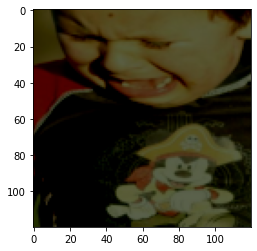

In [ ]:
import matplotlib.pyplot as plt
sample = train_set[1406][0].numpy().transpose(1,2,0)
plt.imshow(sample)
print(train_set [0][1])

In [ ]:
train_loaders = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True ) 

In [ ]:
images,labels = next(iter(train_loaders))
labels

tensor([6, 3, 4, 0, 6, 6, 6, 5, 6, 3, 4, 2, 1, 4, 4, 6, 3, 6, 3, 6, 3, 6, 4, 3,
        6, 3, 2, 3, 6, 6, 0, 3, 3, 6, 1, 3, 1, 4, 1, 3, 4, 6, 0, 3, 5, 6, 1, 3,
        5, 4, 4, 3, 3, 3, 3, 6, 3, 3, 3, 6, 3, 2, 4, 4])

In [ ]:
qa = 0 , ws = 0 , ed=0 , rf=0 , tg=0 , yh=0 , uj=0
for hj in range(5):
  for images , labels in train_loaders:
    qa+= torch.sum(labels==0)
    ws+= torch.sum(labels==1)
    ed+= torch.sum(labels==2)
    rf+= torch.sum(labels==3)
    tg+= torch.sum(labels==4)
    yh+= torch.sum(labels==5)
    uj+= torch.sum(labels==6)

  print(qa)
  print(ws)
  print(ed)
  print(rf)
  print(tg)
  print(yh)
  print(uj)

SyntaxError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


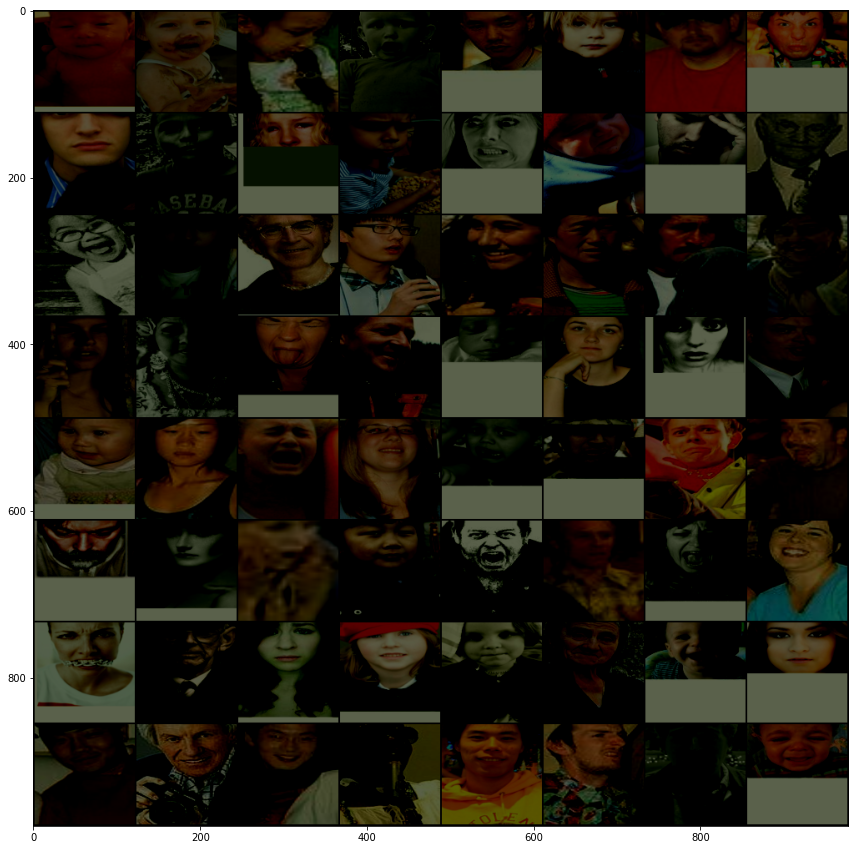

In [ ]:
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(images , nrows = 1)
sample = grid.numpy().transpose(1,2,0)
plt.figure(figsize=(15,15))
plt.imshow(sample)

In [ ]:
device = torch.device ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn

model = torchvision.models.resnet152( pretrained = True  )
model.fc = nn.Sequential(nn.Linear(model.fc.in_features,500),nn.ReLU(),nn.Dropout(),nn.Linear(500,7))
print(model)
optim = torch.optim.Adam(model.parameters() , lr = 1e-4)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
crit = nn.CrossEntropyLoss( )
scalar = torch.cuda.amp.GradScaler()

In [ ]:
num_epochs = 50
total_step = len(train_loaders)

losses = []
train_accuracy = []


for epoch in range(num_epochs):
  for i, (images,labels) in enumerate(train_loaders):
        images = images.to(device)
        labels = labels.to(device)
        model = model.to(device)
        optim.zero_grad()
        with torch.cuda.amp.autocast():

          outputs = model(images)
          loss = crit(outputs, labels)
        
        
        loss.backward()
        optim.step()

        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax.squeeze()).float().mean()

        losses.append(loss.item()/ total_step)
        train_accuracy .append(accuracy.item())

        if (i+1) % 37 == 1:
            print ('Epoch [{}/{}], Step [{}/{}], Log_Loss: {:.4f} , Accuracy at the step {:.3f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item() , accuracy.item() ))

Epoch [1/50], Step [1/192], Log_Loss: 1.9892 , Accuracy at the step 0.156
Epoch [1/50], Step [38/192], Log_Loss: 1.2691 , Accuracy at the step 0.547
Epoch [1/50], Step [75/192], Log_Loss: 0.9613 , Accuracy at the step 0.656
Epoch [1/50], Step [112/192], Log_Loss: 1.0703 , Accuracy at the step 0.594
Epoch [1/50], Step [149/192], Log_Loss: 0.8661 , Accuracy at the step 0.672
Epoch [1/50], Step [186/192], Log_Loss: 0.9133 , Accuracy at the step 0.641
Epoch [2/50], Step [1/192], Log_Loss: 0.6217 , Accuracy at the step 0.844
Epoch [2/50], Step [38/192], Log_Loss: 0.4261 , Accuracy at the step 0.828
Epoch [2/50], Step [75/192], Log_Loss: 0.7430 , Accuracy at the step 0.781
Epoch [2/50], Step [112/192], Log_Loss: 0.3988 , Accuracy at the step 0.875
Epoch [2/50], Step [149/192], Log_Loss: 0.5489 , Accuracy at the step 0.812
Epoch [2/50], Step [186/192], Log_Loss: 0.6566 , Accuracy at the step 0.828
Epoch [3/50], Step [1/192], Log_Loss: 0.2924 , Accuracy at the step 0.938
Epoch [3/50], Step [38

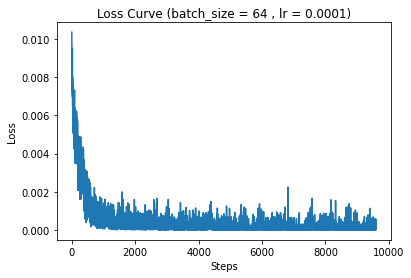

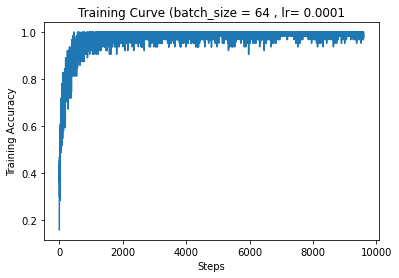

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Loss Curve (batch_size = 64 , lr = 0.0001)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()


plt.plot(train_accuracy)
plt.title("Training Curve (batch_size = 64 , lr= 0.0001")
plt.xlabel("Steps")
plt.ylabel("Training Accuracy")
plt.show()

In [ ]:
test_set = RAF_Dataset ( csv_file = '/content/drive/MyDrive/Single Emotions (1)/Test_set/test_labels.csv' , 
                         root_dir = '/content/drive/MyDrive/Single Emotions (1)/Test_set/Test' ,
                         transform = transform)

test_loaders = torch.utils.data.DataLoader(test_set, batch_size=32,shuffle=False )

In [ ]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images1, labels1 in test_loaders:
        images1 = images1.to(device)
        labels1 = labels1.to(device)
        model = model.to(device)
        outputs1 = model(images1)
        _, predicted = torch.max(outputs1.data, 1)
        total += labels1.size(0)
        correct += (predicted == labels1).sum().item()
    
    print('Accuracy of model is : {} %' .format(100*correct/total))

Accuracy of model is : 77.21642764015645 %


In [ ]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loaders):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([[2.1700e+02, 6.0000e+00, 1.2000e+01, 1.7000e+01, 1.0000e+01, 1.5000e+01,
         5.2000e+01],
        [1.3000e+01, 3.3000e+01, 4.0000e+00, 2.0000e+00, 8.0000e+00, 6.0000e+00,
         8.0000e+00],
        [4.0000e+00, 0.0000e+00, 5.8000e+01, 2.3000e+01, 1.0000e+01, 1.4000e+01,
         5.1000e+01],
        [5.0000e+00, 2.0000e+00, 1.4000e+01, 1.0700e+03, 2.1000e+01, 1.6000e+01,
         5.7000e+01],
        [4.0000e+00, 2.0000e+00, 1.9000e+01, 3.5000e+01, 3.0900e+02, 8.0000e+00,
         1.0100e+02],
        [4.0000e+00, 6.0000e+00, 1.0000e+01, 1.9000e+01, 1.0000e+00, 1.1100e+02,
         1.1000e+01],
        [1.5000e+01, 2.0000e+00, 1.9000e+01, 4.7000e+01, 1.9000e+01, 7.0000e+00,
         5.7100e+02]])
tensor([0.6596, 0.4459, 0.3625, 0.9030, 0.6464, 0.6852, 0.8397])


Text(0.5, 69.0, 'Predicted label')

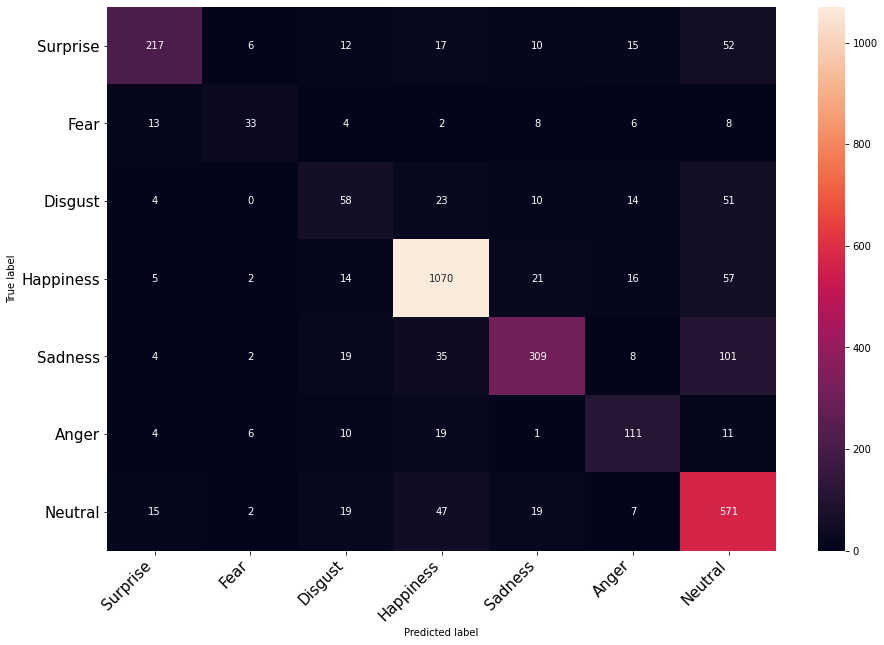

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(15,10))


class_names = ['Surprise' , 'Fear' , 'Disgust' , 'Happiness' , 'Sadness' ,'Anger' ,'Neutral']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
torch.save('model.state_dict' , 'resnet152.pth')